In a new python environment with python>=3.10

In [1]:
# ! pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

In [2]:
# here are the training parameters
batch_size = 10
learning_rate = 1e-3
weight_decay = 2e-4
lr_decay_epochs = 20
lr_decay = 0.1
nb_epochs = 50

In [3]:
import torch
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="train",
    transforms=train_transform,
    download=True,
)
val_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="val",
    transforms=val_transform,
    download=True,
)
test_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="test",
    transforms=val_transform,
    download=True,
)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [ ]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

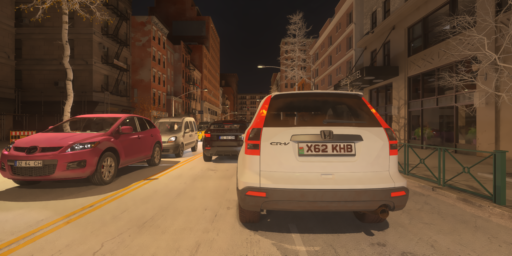

In [5]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

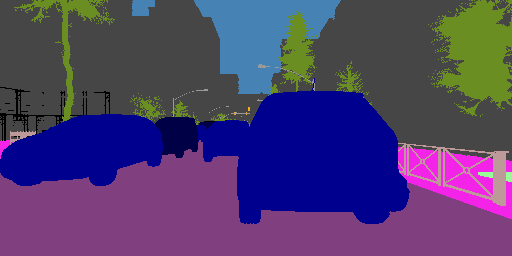

In [6]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, tgt_masks, alpha=1, colors=val_set.color_palette
)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [7]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

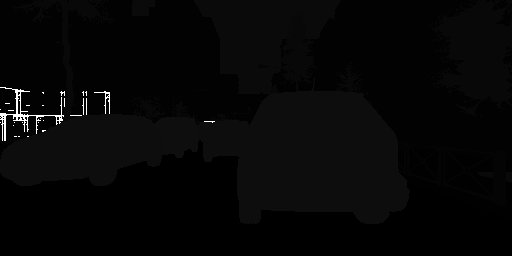

In [8]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [9]:
im.size

(512, 256)

**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

**Q3/ please study the dataset a bit. What it is about?**



In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): An additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0

    for _, label in dataloader:
        label = label.cpu().numpy()
        # Flatten label
        flat_label = label.flatten()
        flat_label = flat_label[flat_label != 255]

        # Sum up the number of pixels of each class and the total pixel
        # counts for each label
        class_count += np.bincount(flat_label, minlength=num_classes)
        total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [12]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)


Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**


**Q6/Do we need a backbone with Unet?**






In [13]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(
                x1,
                size=[2 * x1.size()[2], 2 * x1.size()[3]],
                interpolation=v2.InterpolationMode.BILINEAR,
            )
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]
        )

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)


# please note that we have added dropout layer to be abble to use MC dropout
class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [14]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()


def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?** REVIEW

IoU (Intersection over Union) is a widely used evaluation metric in computer vision, especially for tasks like object detection, semantic segmentation, and instance segmentation. It measures the overlap between two regions: a predicted region (output from a model) and the ground truth (actual label).

### Training function

**Q8/Please complete the training and the test function**

In [15]:
from torchmetrics.utilities.compute import _safe_divide


def train(model, data_loader, optim, criterion, metric, iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()

    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()  # [B, 3, H, W]
        labels = batch_data[1].squeeze(1).cuda()  # [B, 1, H, W]

        # Forward propagation
        logits = model(img)

        # Flatten logits and labels
        flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])
        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(
            flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach()
        )

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

### Validation function

In [16]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()

    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].squeeze(1).cuda()

        with torch.no_grad():
            # Forward propagation
            logits = model(img)

            # Flatten logits and labels
            flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

## E. Training Process

**Q9/ please train your DNN and comment?**



In [17]:
from torch import optim
from torch.optim import lr_scheduler

from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

print("\nTraining...\n")
num_classes = 19

# Intialize UNet
model = UNet(num_classes).cuda()

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion combines LogSoftMax and NLLLoss.
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay)
metric = MeanIntersectionOverUnion(num_classes=num_classes).to("cuda")


Training...



In [18]:
# Start Training
train_loss_history = []
val_loss_history = []
train_miou_history = []
val_miou_history = []

best_val_miou = -1
model_save_path = "model.pth"

for epoch in range(nb_epochs):
    print(f">>>> [Epoch: {epoch}] Training")

    # Train the model
    train_loss, train_iou_per_class, train_miou = train(
        model, train_loader, optimizer, criterion, metric
    )

    print(
        f">>>> [Epoch: {epoch}] Avg. loss: {train_loss:.4f} | Mean IoU: {train_miou:.4f}"
    )

    if (epoch + 1) % 5 == 0:
        train_loss_history.append(train_loss)
        train_miou_history.append(train_miou)

        val_loss, val_iou_per_class, val_miou = test(
            model, val_loader, criterion, metric
        )
        val_loss_history.append(val_loss)
        val_miou_history.append(val_miou)

        print(f">>>> [Epoch: {epoch}] Validation")
        print(
            f">>>> [Epoch: {epoch}] Avg. loss: {val_loss:.4f} | Mean IoU: {val_miou:.4f}"
        )

        for cls_name, cls_iou in zip(val_set.classes, val_iou_per_class):
            print(f"{cls_name.name}: {cls_iou:.4f}")

        # Check if this is the best model so far
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            print("\nBest model so far. Saving...")
            torch.save(model.state_dict(), model_save_path)
            print(f"\nModel saved to {model_save_path}")

    # Update the learning rate
    scheduler.step()

>>>> [Epoch: 0] Training


>>>> [Epoch: 0] Avg. loss: 2.2889 | Mean IoU: 0.1022
>>>> [Epoch: 1] Training
>>>> [Epoch: 1] Avg. loss: 1.7357 | Mean IoU: 0.1894
>>>> [Epoch: 2] Training
>>>> [Epoch: 2] Avg. loss: 1.4151 | Mean IoU: 0.2526
>>>> [Epoch: 3] Training
>>>> [Epoch: 3] Avg. loss: 1.2473 | Mean IoU: 0.2738
>>>> [Epoch: 4] Training
>>>> [Epoch: 4] Avg. loss: 1.1422 | Mean IoU: 0.2922
>>>> [Epoch: 4] Validation
>>>> [Epoch: 4] Avg. loss: 1.2801 | Mean IoU: 0.2643
road: 0.7792
sidewalk: 0.3760
building: 0.6446
wall: 0.0000
fence: 0.3036
pole: 0.0951
traffic_light: 0.0000
traffic_sign: 0.0000
vegetation: 0.3590
terrain: 0.0000
sky: 0.7235
person: 0.1041
rider: nan
car: 0.4823
truck: 0.0968
bus: nan
train: nan
motorcycle: nan
bicycle: 0.0000

Best model so far. Saving...

Model saved to model.pth
>>>> [Epoch: 5] Training
>>>> [Epoch: 5] Avg. loss: 1.0761 | Mean IoU: 0.3004
>>>> [Epoch: 6] Training
>>>> [Epoch: 6] Avg. loss: 1.0121 | Mean IoU: 0.3110
>>>> [Epoch: 7] Training
>>>> [Epoch: 7] Avg. loss: 0.9659 | M

Load a model

In [19]:
# Loading a model
model = UNet(19)
model.load_state_dict(torch.load("model.pth"))
model = model.to("cuda")

/tmp/ipykernel_1609726/1164147947.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**
Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.

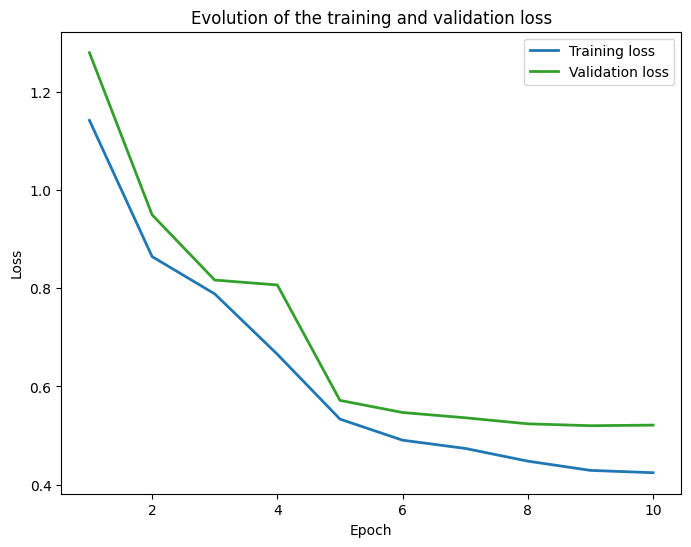

In [20]:
plot_losses(train_loss_history, val_loss_history)

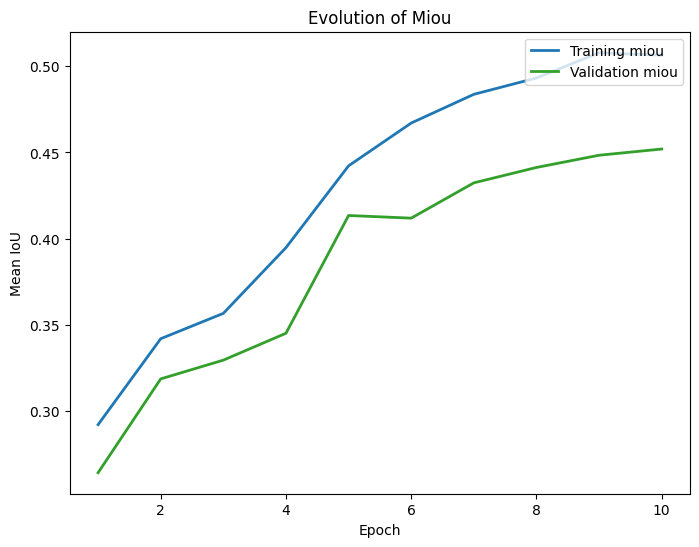

In [21]:
plot_accu(train_miou_history, val_miou_history)

**Q11/ what should we have done to avoid overfitting?**



In [22]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss, " | Mean IoU: ", miou)
# Print per class IoU on last epoch or if best iou
for key, class_iou in zip(test_set.classes[:19], iou, strict=True):
    print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5309235453605652  | Mean IoU:  0.5042185187339783
MUADClass(name='road', id=0, color=(128, 64, 128)): 0.9384
MUADClass(name='sidewalk', id=1, color=(244, 35, 232)): 0.7316
MUADClass(name='building', id=2, color=(70, 70, 70)): 0.8050
MUADClass(name='wall', id=3, color=(102, 102, 156)): 0.5138
MUADClass(name='fence', id=4, color=(190, 153, 153)): 0.4337
MUADClass(name='pole', id=5, color=(153, 153, 153)): 0.2541
MUADClass(name='traffic_light', id=6, color=(250, 170, 30)): 0.1770
MUADClass(name='traffic_sign', id=7, color=(220, 220, 0)): 0.0000
MUADClass(name='vegetation', id=8, color=(107, 142, 35)): 0.6032
MUADClass(name='terrain', id=9, color=(152, 251, 152)): 0.0051
MUADClass(name='sky', id=10, color=(70, 130, 180)): 0.9103
MUADClass(name='person', id=11, color=(220, 20, 60)): 0.4842
MUADClass(name='rider', id=12, color=(255, 0, 0)): nan
MUADClass(name='car', id=13, color=(0, 0, 142)): 0.7754
MUADClass(name='truck', id=14, color=(0, 0,

## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [23]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

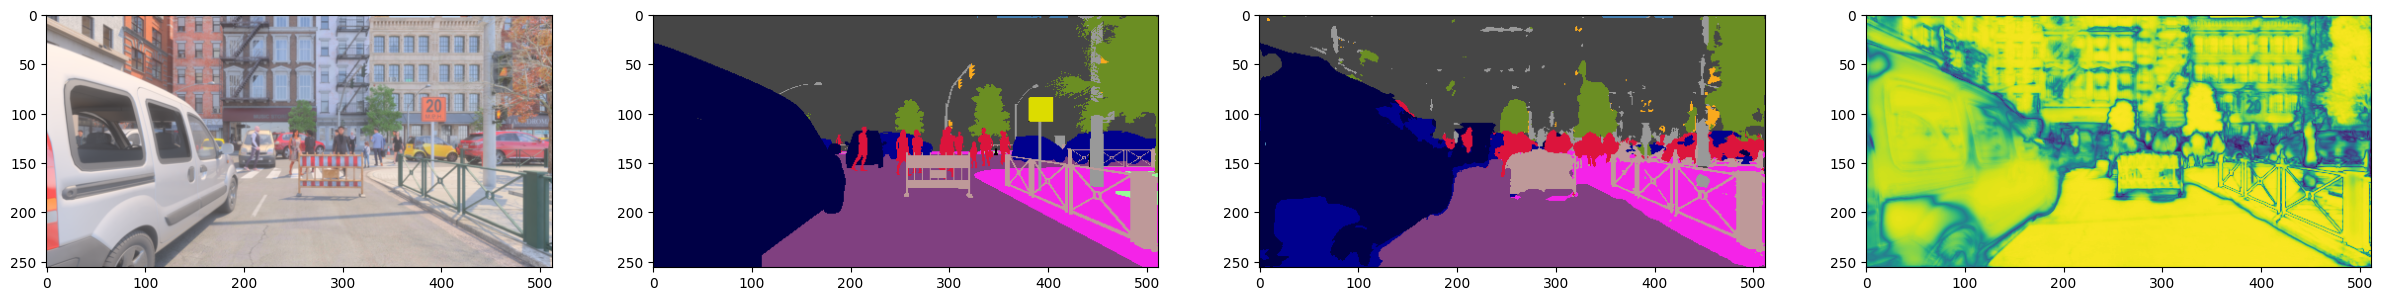

In [24]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, target_masks, alpha=1, colors=test_set.color_palette
)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(
    img, pred_masks, alpha=1, colors=test_set.color_palette
)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**


### Now let's load the OOD test set

In [25]:
test_ood_set = MUAD(
    root="./data",
    target_type="semantic",
    version="small",
    split="ood",
    transforms=val_transform,
    download=True,
)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [26]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

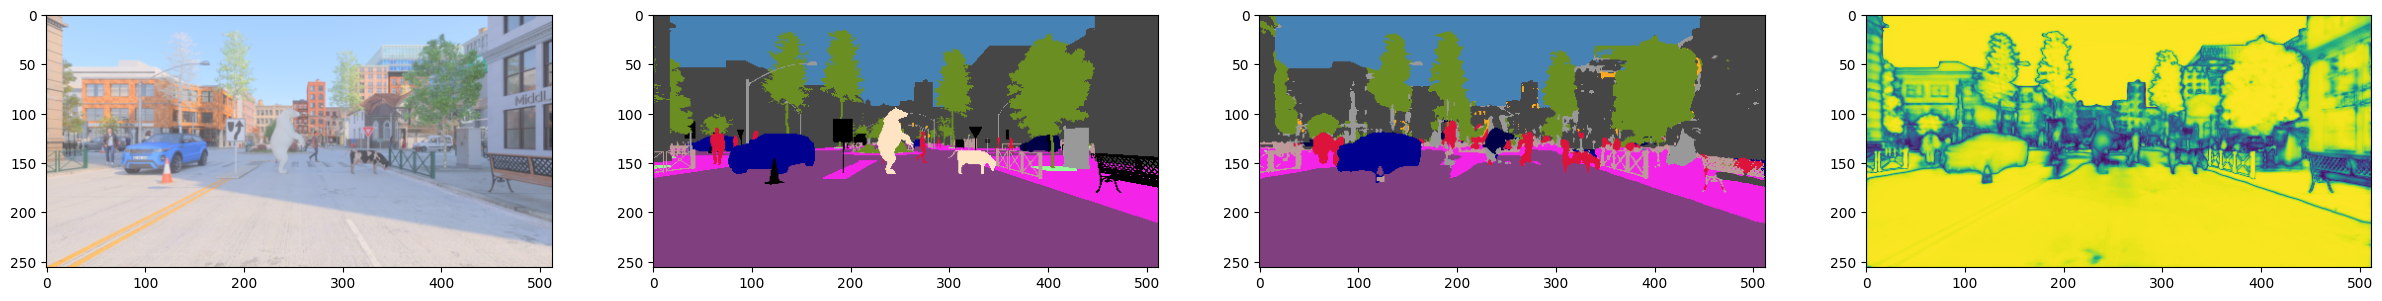

In [27]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(
    img, target_masks, alpha=1, colors=test_set.color_palette
)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(
    img, pred_masks, alpha=1, colors=test_set.color_palette
)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**


## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

(<Figure size 900x1260 with 2 Axes>,
 array([<Axes: title={'center': 'Reliability Diagram'}, xlabel='Top-class Confidence (%)', ylabel='Success Rate (%)'>,
        <Axes: xlabel='Top-class Confidence (%)', ylabel='Density (%)'>],
       dtype=object))

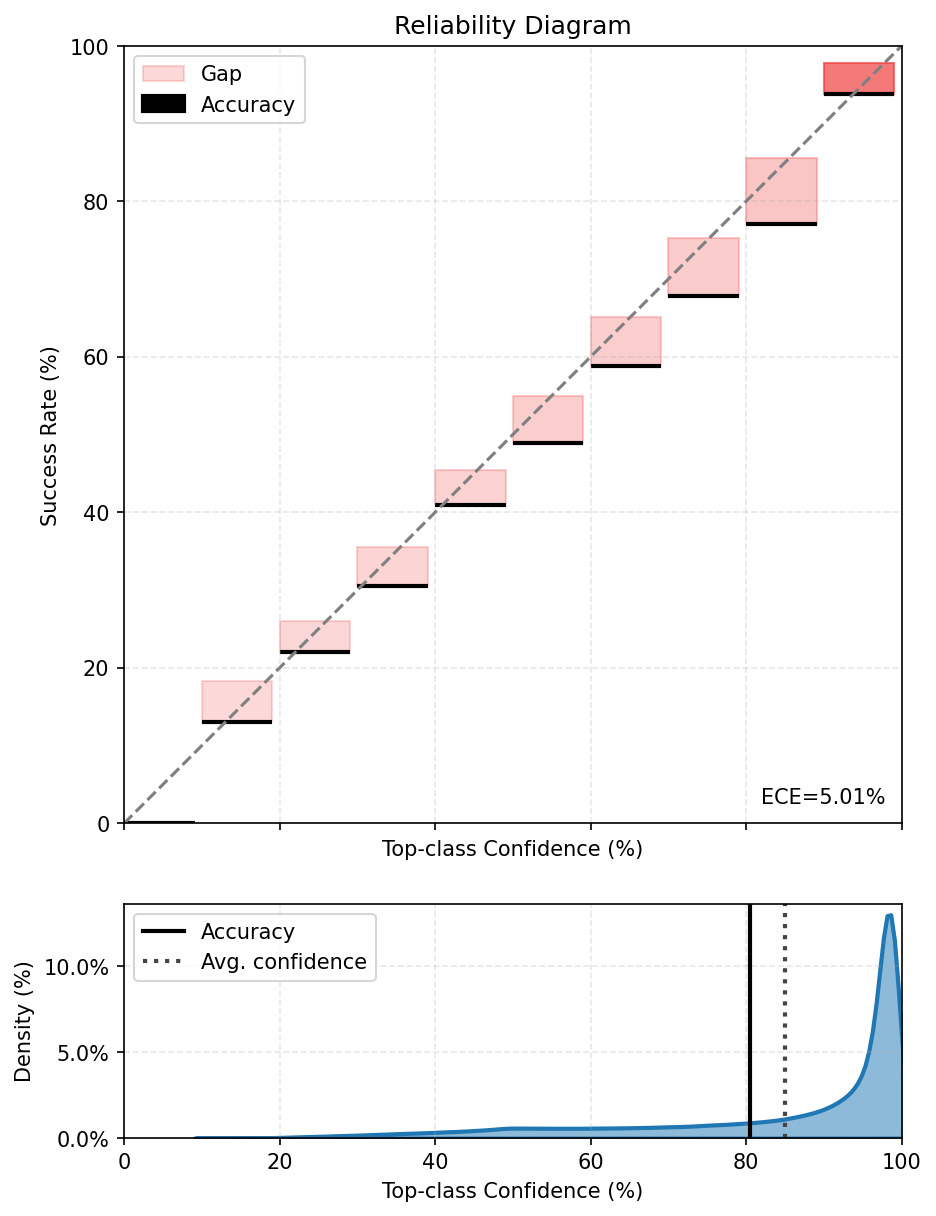

In [28]:
from torch_uncertainty.metrics import CalibrationError

calibration_error = CalibrationError(task="multiclass", num_classes=19).to("cuda")

for img, target in test_ood_set:
    batch_img = img.unsqueeze(0).cuda()
    batch_target = target.cuda()

    with torch.no_grad():
        # Forward propagation
        outputs = model(batch_img)
        outputs_proba = outputs.softmax(dim=1)

    calibration_error.update(outputs_proba.cuda(), batch_target.cuda())

calibration_error.plot()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

After temperature scaling

In [29]:
from torch_uncertainty.post_processing import TemperatureScaler

cal_set = [(img, target.squeeze(0)) for img, target in val_set]
cal_set = [
    (img, target.masked_fill(target == 255, 18)) for img, target in cal_set
]  # review 18, no sense

scaled_model = TemperatureScaler(model=model, device="cuda")
scaled_model.fit(cal_set)

100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


(<Figure size 900x1260 with 2 Axes>,
 array([<Axes: title={'center': 'Reliability Diagram'}, xlabel='Top-class Confidence (%)', ylabel='Success Rate (%)'>,
        <Axes: xlabel='Top-class Confidence (%)', ylabel='Density (%)'>],
       dtype=object))

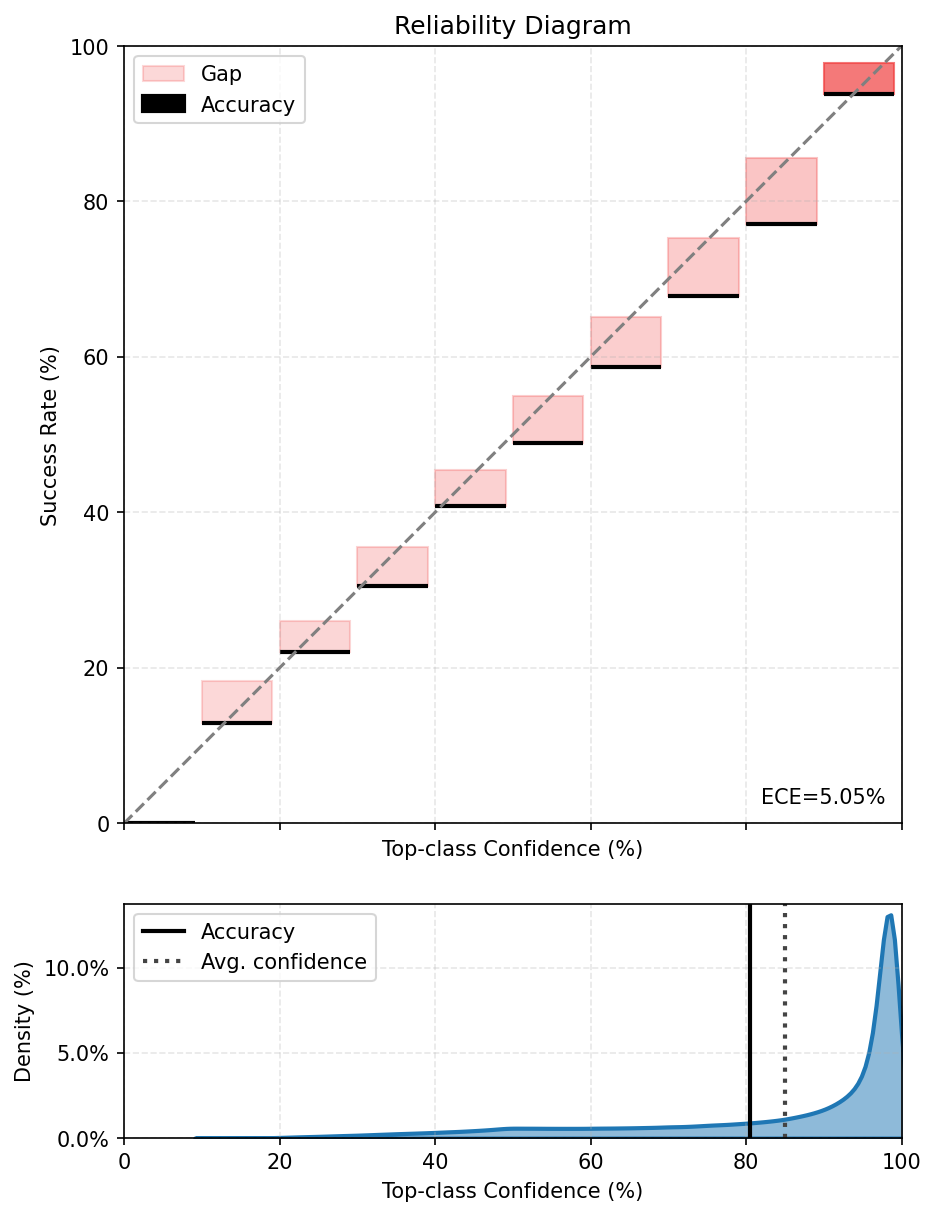

In [30]:
calibration_error = CalibrationError(task="multiclass", num_classes=19).to("cuda")

for img, target in test_ood_set:
    batch_img = img.unsqueeze(0).cuda()
    batch_target = target.cuda()

    with torch.no_grad():
        # Forward propagation
        outputs = scaled_model(batch_img)
        outputs_proba = outputs.softmax(dim=1)

    calibration_error.update(outputs_proba.cuda(), batch_target.cuda())

calibration_error.plot()

Now let's see the new confidence score image after scaling

In [31]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
scaled_model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = scaled_model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

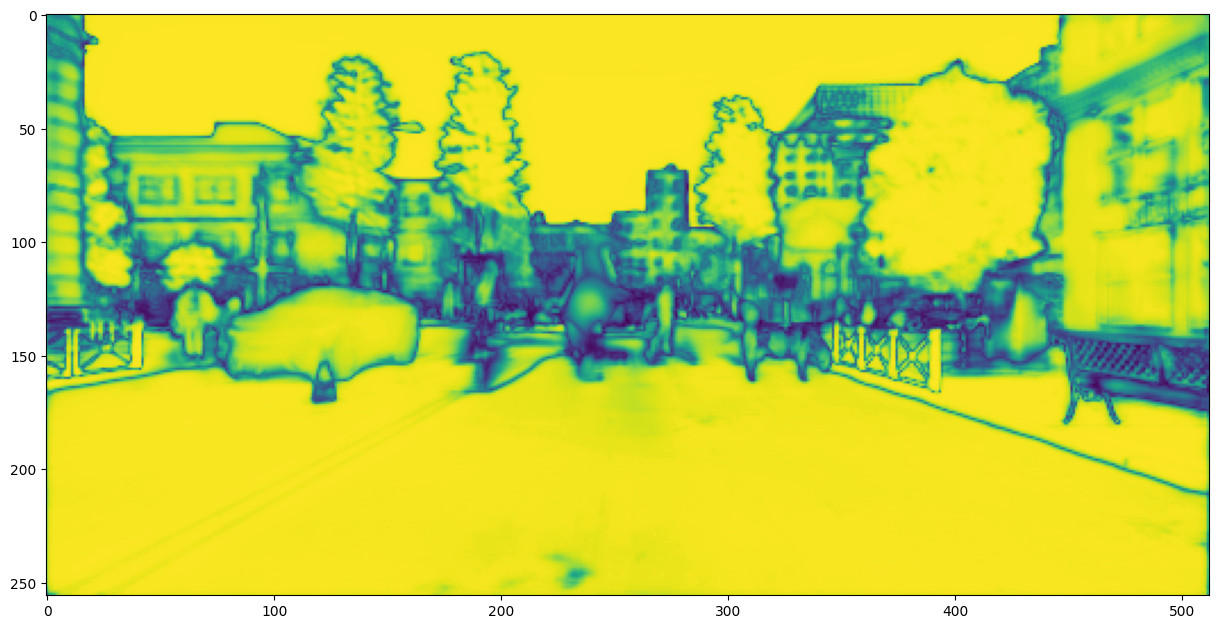

In [32]:
confidence_img = F.to_pil_image(confidence)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(confidence_img)
plt.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [33]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

**Try the MC dropout code with a low number of estimators like 3 and a high number 20. Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

In [34]:
mc_model = mc_dropout(model, num_estimators=100)

In [35]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
scaled_model.eval()

with torch.no_grad():
    # Forward propagation
    outputs = mc_model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    confidence, pred = outputs_proba.max(0)

    # Forward propagation
    outputs2 = model(batch_img)
    outputs_proba2 = outputs2.softmax(dim=1)
    # remove the batch dimension
    outputs_proba2 = outputs_proba2.squeeze(0)
    confidence2, pred2 = outputs_proba2.max(0)

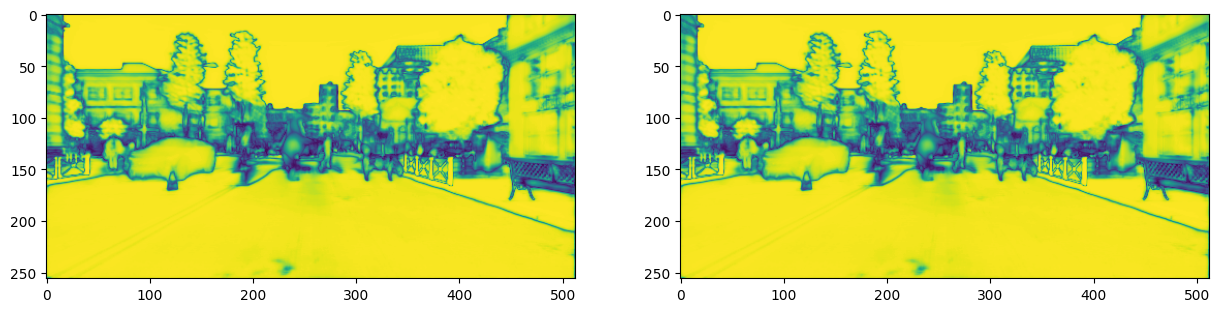

In [36]:
confidence_img = F.to_pil_image(confidence)
confidence_img2 = F.to_pil_image(confidence2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(confidence_img)
ax2.imshow(confidence_img2)
plt.show()

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [37]:
from torch_uncertainty.models import deep_ensembles

Test your ensemble obtained either using option 1 or 2.

In [38]:
results = trainer.test(ens_routine, test_loader)

NameError: name 'trainer' is not defined

Save the ensemble model

In [ ]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/alafage/miniconda3/envs/test_tp/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alafage/thesis/torch-uncertainty/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | PackedUNet       | 2.1 M  | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | RepeatTarget     | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total pa

Epoch 49: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       Segmentation        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Brier     │          0.41144          │
│     NLL      │          0.88911          │
│     mAcc     │          50.58%           │
│     mIoU     │          37.54%           │
│    pixAcc    │          78.32%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.27004          │
│     aECE     │          0.27004          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │           5.81%           │
│     AURC     │           7.96%           │
└──────────────┴───────────────────────────┘

**Please conclude your report**